# Build a Pytorch model to predict a score from a DNA sequence
This tutorial shows some examples for how to build Pytorch models that take raw DNA sequences as input and feed it into a neural network that makes some sort of prediction about the sequence. 

This isn't necessarily "the best" way to do this, but when I was first learning, I had trouble finding a clear example and spent a lot of time looking through other more complex codebases. If you're just getting started with Pytorch and are also using DNA sequences as your input, perhaps this tutorial can be a helpful example of how to "connect some Pytorch tubes together"!

In [40]:
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch import nn

## 1. Generate synthetic data (practice task)

Usually scientists might be interested in predicting something like a binding score, an expression strength, or classifying a TF binding event. But here, we are going to keep it simple: the goal in this tutorial is to observe if a deep learning model can learn to detect a very small, simple pattern in a DNA sequence and score it appropriately, just to convince ourselves that we have actually set up Pytorch to correctly learn from input that looks like a DNA sequence. 

So arbitrarily, let's say that given an 8-mer DNA sequence, we will score it based on the following rules:
* A = 20 points
* C = 17 points
* G = 14 points
* T = 11 points

For every 8-mer, sum up its total points based on the nucleotides in its sequence, then take the average. 
For example, 

`AAAAAAAA` would score `20.0` 

(`mean(20 + 20 + 20 + 20 + 20 + 20 + 20 + 20) = 20.0`)  

while `ACAAAAAA` would score `19.625` 

(`mean(20 + 17 + 20 + 20 + 20 + 20 + 20 + 20) = 19.625`)

These values for the nucleotides are arbitrary. It's just a way to assign sequences a score for the purposes of our Pytorch practice.

However, since many recent papers use methods like CNNs to automatically detect "motifs," or short patterns in the DNA that can activate or repress a biological response, let's add one more piece to our scoring system. To simulate something motifs influencing gene expression, let's say a given sequence gets a `+10` bump if it has a `TAT` in it, and a `-10` bump if it has a `GCG` in it. Again, these motifs don't mean anything in real life, they are just a mechanism for simulating a really simple activation or repression effect. 

![](scoring.png)

So let's implement this basic scoring function!

In [2]:
def kmers(k):
    '''Generate all k-mers for a given k'''
    
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

In [3]:
seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
                  
def score_seqs_motif(seqs):
    '''
    Calculate the scores for a list of sequences based on 
    the above score_dict
    '''
    data = []
    for seq in seqs:
        # get the average score by nucleotide
        score = np.mean([score_dict[base] for base in seq])
        
        # give a + or - bump if this k-mer has a specific motif
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df

In [5]:
mer8 = score_seqs_motif(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


Spot check scores of a couple seqs with motifs:

In [8]:
mer8[mer8['seq'].isin(['TGCGTTTT','CCCCCTAT'])]

,seq,score
21875,CCCCCTAT,25.875
59135,TGCGTTTT,2.500


As expected, the distribution of scores across all 8-mers has 3 groups:
* No motif (centered around ~15)
* contains `TAT` (~25)
* contains `GCG` (~5)

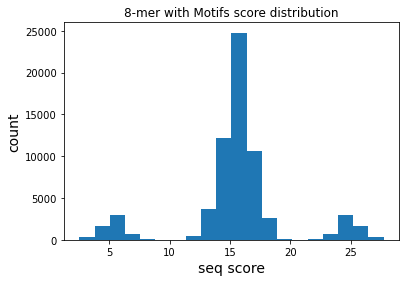

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

Our goal is now to train a model to predict this score by looking at the DNA sequence.

## 2. Prepare data for Pytorch training
For neural networks to make predictions, you have to give it your input as a matrix of numbers. For example, to classify images by whether or not they contain a cat, a network "sees" the image as a matrix of pixel values and learns relevant patterns in the relative arragnement of pixels (e.g. patterns that correspond to cat ears, or a nose with whiskers). 

We similarly need to turn our DNA sequences (strings of ACGTs) into a matrix of numbers. So how do we pretend our DNA is a cat? 

One common strategy is to one-hot encode the DNA: treat each nucleotide as a vector of length 4, where 3 positions are 0 and one position is a 1, depending on the nucleotide.

![](cat.png)

This one-hot encoding has the nice property that it makes you DNA appear like how a computer sees a picture of a cat!

In [30]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    # TODO: can this just be a torch.tensor right here?
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [31]:
# look DNA seq of 8 As
a8 = one_hot_encode("AAAAAAAA")
print("AAAAAA:\n",a8)

# look at DNA seq of random nucleotides
s = one_hot_encode("AGGTACCT")
print("AGGTACC:\n",s)
print("shape:",s.shape)

AAAAAA:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
AGGTACC:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
shape: (8, 4)


With this one-hot encoding scheme, we can prepare our train, val, and test sets. This `quick_split` just randomly picks some indices in the pandas dataframe to split (sklearn has a function to do this too). 

In [47]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [48]:
full_train_df, test_df = quick_split(mer8)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (41942, 2)
Val: (10486, 2)
Test: (13108, 2)


In [69]:
def plot_train_test_hist(train_df, val_df,test_df,bins=20):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label='train',alpha=0.5)
    plt.hist(val_df['score'].values,bins=bins,label='val',alpha=0.75)
    plt.hist(test_df['score'].values,bins=bins,label='test',alpha=0.4)
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

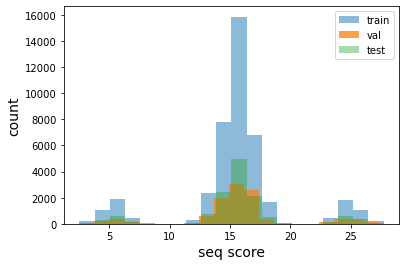

In [70]:
plot_train_test_hist(train_df, val_df,test_df)

But the real trick here is using the Pytorch [DataLoader and Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) objects. It took me a lot of googling around to figure something out, but this is a solution I was able to concoct from a lot of combing through docs and stack overflow posts!

In short, a Dataset wraps your data in an object that can smoothly give your properly formatted X examples and Y labels to the model you're training. The DataLoader accepts a Dataset and some other details about how to form batches from your data and makes it easier to iterate through training steps.

In [33]:
from torch.utils.data import Dataset, DataLoader

#### Here is a custom defined Dataset object specialized for one-hot encoded DNA:


In [34]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

#### Here is how I constructed DataLoaders from Datasets. 

In [53]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    #test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    # TODO: What is the reason for this?
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [83]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

In [71]:
# # inspect some stuff about a batch
# for xb, yb in mer8_train_dl:
#     break
    
# print(xb.shape)
# print(xb.permute(0,2,1).unsqueeze(1).shape)

These dataloaders are now ready to be used in a training loop!

## 3. Define Pytorch models
The primary model I was interested in trying was a Convolutional Neural Network, as these have been shown to be useful for learning motifs from genomic data. But as a point of comparison, I included a simple Linear model. Here are some model definitions:

In [90]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        return out

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out
    
    # does this work with Conv1D?

In [91]:
seq_len = len(train_df['seq'].values[0])

model_lin = DNA_Linear(seq_len)

In [96]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    #loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss


def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
#     # create early stopping object
#     early_stopping = EarlyStopping(patience=patience, verbose=False)
    
    # loops through epochs
    for epoch in range(epochs): #tqdm?
#     with tqdm.trange(epochs) as pbar:
#         for i in pbar:
        train_loss = train_step(model, train_dl, loss_func, device,opt)
        train_losses.append(train_loss)


        val_loss = val_step(model, val_dl, loss_func, device)
        #print(epoch, val_loss)
        val_losses.append(val_loss)
            
#             pbar.set_description(f"E:{i} | train loss:{train_loss:.3f} | val loss: {val_loss:.3f}")
            
            # copied from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
#             early_stopping(val_loss, model,i)

#             if early_stopping.early_stop:
#                 print("Early stopping")
#                 break
    
    # Epoch and value of best model checkpoint
#     estop = early_stopping.best_model_epoch
#     best_val_score = early_stopping.val_loss_min 

    # load the last checkpoint with the best model
#     model.load_state_dict(torch.load('checkpoint.pt'))
    # ^^ Does this need to be returned? I dont' think so... loads in place

    return train_losses, val_losses#,estop,best_val_score


def run_model(train_dl,val_dl, model, loss_func, device,lr=0.01, epochs=20, opt=None):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, val_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl, device)
#     train_losses, \
#     val_losses,\
#     epoch_stop,\
#     best_val_score = fit(epochs, model, loss_func, optimizer, train_dl, val_dl,device)

    return model, train_losses, val_losses
    #return train_losses, val_losses, epoch_stop, best_val_score

In [93]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [94]:
model_lin.to(DEVICE)

DNA_Linear(
  (lin): Linear(in_features=32, out_features=1, bias=True)
)

In [97]:
loss_func = torch.nn.MSELoss()
m,lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    loss_func,
    DEVICE
)

In [99]:
lin_val_losses

[13.152802312553735,
 13.152917835381839,
 13.184130444000086,
 13.159280503225899,
 13.15374952524008,
 13.14685671051654,
 13.145709527441502,
 13.156948304235446,
 13.145646859961522,
 13.146106549535297,
 13.158532394745322,
 13.169095256731934,
 13.148248721778836,
 13.144236608472871,
 13.145988883441035,
 13.149706992397276,
 13.142403423251848,
 13.153207543922612,
 13.16568323612304,
 13.151675434756456]

In [111]:
# to plot loss
lin_data_label = [lin_train_losses,lin_val_losses,"Lin"]

In [112]:
len(lin_data_label)

3

In [108]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Test",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

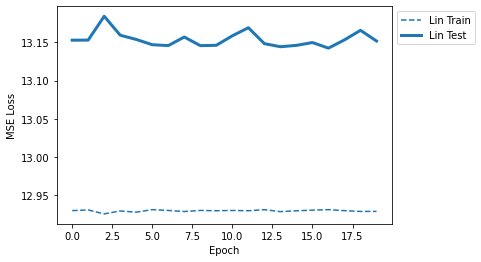

In [113]:
quick_loss_plot([lin_data_label])

In [116]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(one_hot_encode(dna)).unsqueeze(0).float().to(DEVICE)
model_lin(dna_oh)

tensor([[7.1882]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
quic